<a href="https://colab.research.google.com/github/LevBahn/Gross-Pitaevskii-Eigenvalue-problem/blob/main/Gross-Pitaevskii/src/overleaf/energy_perturbation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [56]:
import torch
import torch.nn as nn
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import math
import numpy as np
import os
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [57]:
class GrossPitaevskiiBoxPINN(nn.Module):
    """
    Physics-Informed Neural Network (PINN) for solving the 1D Gross-Pitaevskii Equation
    for a Bose-Einstein condensate in a box potential.
    """

    def __init__(self, layers, hbar=1.0, m=1.0, mode=1, mu=1.0, gamma=1.0, L=10.0):
        """
        Parameters
        ----------
        layers : list of int
            Neural network architecture, each entry defines the number of neurons in that layer.
        hbar : float, optional
            Reduced Planck's constant (default is 1.0).
        m : float, optional
            Mass of the particle (default is 1.0).
        mode : int, optional
            Mode number (default is 1). For box, mode starts from 1.
        gamma : float, optional
            Interaction strength parameter.
        L : float, optional
            Length of the box (default is 10.0).
        """
        super().__init__()
        self.layers = layers
        self.network = self.build_network()
        self.hbar = hbar  # Planck's constant, fixed
        self.m = m  # Particle mass, fixed
        self.mode = mode  # Mode number (n) - starts from 1 for box
        self.gamma = gamma  # Interaction strength parameter
        self.L = L  # Length of the box
        self.mu = mu


    def build_network(self):
        """
        Build the neural network with tanh activation functions between layers.
        """
        layers = []
        for i in range(len(self.layers) - 1):
            layers.append(nn.Linear(self.layers[i], self.layers[i + 1]))
            if i < len(self.layers) - 2:
                layers.append(nn.Tanh())
        return nn.Sequential(*layers)

    def box_eigenfunction(self, x, n):
        """
        Compute the analytic eigenfunction for a particle in a box.

        For the linear case (gamma = 0), the solution is:
        phi_n(x) = sqrt(2/L) * sin(n*pi*x/L)

        This corresponds to equation (22) in the paper.
        """
        # Ensure n is at least 1 (no n=0 mode in box)
        n = max(1, n)

        # Normalization factor
        norm_factor = torch.sqrt(torch.tensor(2.0 / self.L))

        # Sine function
        phi_n = norm_factor * torch.sin(n * torch.pi * x / self.L)

        return phi_n

    def energy_eigenvalue(self, n):
        """
        Compute the energy eigenvalue for mode n in a box potential.

        E_n = (n²π²ħ²)/(2mL²)

        With ħ=1 and m=1, this simplifies to:
        E_n = (n²π²)/(2L²)
        """
        return (n ** 2 * np.pi ** 2) / (2 * self.L ** 2)

    def forward(self, inputs):
        """
        Forward pass through the neural network.
        """
        return self.network(inputs)

    def get_complete_solution(self, x, perturbation, mode=None):
        """
        Get the complete solution by combining the base sine solution with the neural network perturbation.
        """
        if mode is None:
            mode = self.mode

        # Get the base solution (sine function)
        base_solution = self.box_eigenfunction(x, mode)

        # Apply scaling to perturbation
        perturbation_scale = 1.0
        if self.gamma > 0:
            if mode == 1:
                # Special handling for mode 1
                if self.gamma == 20.0:
                    # Apply stronger regularization for γ=20
                    perturbation_scale = 0.8  # Reduced influence of perturbation
                else:
                    perturbation_scale = 1.0 + 0.02 * self.gamma
            if mode == 5:
                # Slightly reduced scaling for mode 5
                perturbation_scale = 0.8 + 0.004 * self.gamma

        # Complete solution is base + perturbation
        complete_solution = base_solution + perturbation * perturbation_scale

        # For mode 1, ensure we have the correct sign (positive peak)
        if mode == 1:
            # Use abs of the solution for mode 1 with γ = 0 to ensure it's positive
            if self.gamma == 0:
                complete_solution = torch.abs(complete_solution)
            else:
                # For γ > 0, we want to preserve the flattening effect
                # Check the sign of the peak value and flip if necessary
                if torch.mean(complete_solution) < 0:
                    complete_solution = -complete_solution

        return complete_solution

    def compute_potential(self, x, potential_type="box"):
        """
        Compute potential function for the 1D domain.

        For the box potential:
        V(x) = 0 for 0 < x < L
        V(x) = ∞ for x <= 0 or x >= L (enforced via boundary conditions)
        """
        if potential_type == "box":
            # Infinite square well / box potential is zero inside the box
            V = torch.zeros_like(x)
        elif potential_type == "harmonic":
            omega = 1.0  # Frequency for harmonic potential
            V = 0.5 * omega ** 2 * x ** 2
        else:
            raise ValueError(f"Unknown potential type: {potential_type}")
        return V

    def pde_loss(self, inputs, predictions, mu, potential_type="box"):
        """
        Compute the PDE loss for the Gross-Pitaevskii equation:
        μψ = -1/2 ∇²ψ + Vψ + γ|ψ|²ψ

        For box potential, V=0 inside the box, so the equation simplifies to:
        μψ = -1/2 ∇²ψ + γ|ψ|²ψ
        """
        # Get the complete solution (base + perturbation)
        u = self.get_complete_solution(inputs, predictions)

        # Compute derivatives with respect to x
        u_x = torch.autograd.grad(
            outputs=u,
            inputs=inputs,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True
        )[0]

        u_xx = torch.autograd.grad(
            outputs=u_x,
            inputs=inputs,
            grad_outputs=torch.ones_like(u_x),
            create_graph=True,
            retain_graph=True
        )[0]
        dx = inputs[1] - inputs[0]  # Grid spacing
        # Compute potential (zero for box potential)
        V = self.compute_potential(inputs, potential_type)

        # Calculate chemical potential
        kinetic = -0.5 * u_xx
        potential = V * u
        eigenvalue = mu * u

        # Compute the integrals for chemical potential
        numerator = torch.sum(u * (-kinetic - potential + eigenvalue)) * dx
        denominator = torch.sum(u ** (4)) * dx
        gamma = numerator / denominator
        interaction = gamma * u ** (3)

        # Use proper integration for calculating chemical potential




        # Residual of the 1D Gross-Pitaevskii equation
        pde_residual = kinetic + potential + interaction - mu * u

        # PDE loss (mean squared residual)
        pde_loss = torch.mean(pde_residual ** 2)

        return pde_loss, pde_residual, gamma, u

    def riesz_loss(self, inputs, predictions, gamma, potential_type="box"):
        """
        Compute the Riesz energy loss for the Gross-Pitaevskii equation.
        E[ψ] = ∫[|∇ψ|²/2 + V|ψ|² + γ|ψ|⁴/2]dx

        This corresponds to Algorithm 2 in the paper and equations (23)-(25)
        """
        # Get the complete solution (base + perturbation)
        u = self.get_complete_solution(inputs, predictions)

        # Ensure inputs require gradients for autograd
        if not inputs.requires_grad:
            inputs = inputs.clone().detach().requires_grad_(True)

        # Compute derivative with respect to x
        u_x = torch.autograd.grad(
            outputs=u,
            inputs=inputs,
            grad_outputs=torch.ones_like(u),
            create_graph=True,
            retain_graph=True
        )[0]

        # Calculate normalization factor for proper numerical integration
        dx = inputs[1] - inputs[0]  # Grid spacing


        # Ensure we are normalized properly
        norm_factor = torch.sum(u ** 2) * dx


        # Kinetic energy term: |∇ψ|²/2 with proper normalization
        kinetic_term = 0.5 * torch.sum(u_x ** 2) * dx / norm_factor

        # Potential term: V|ψ|² with proper normalization
        # For box potential, V=0 inside the box, so this term is zero
        V = self.compute_potential(inputs, potential_type)
        potential_term = torch.sum(V * u ** 2) * dx / norm_factor

        # Interaction term: γ|ψ|⁴/2 with proper normalization
        interaction_term = 0.5 * gamma * torch.sum(u ** 4) * dx / norm_factor

        # Total Riesz energy functional
        riesz_energy = kinetic_term + potential_term + interaction_term

        # Chemical potential using variational approach
        lambda_riesz = riesz_energy

        return riesz_energy, lambda_riesz, u

    def boundary_loss(self, boundary_points, boundary_values):
        """
        Compute the boundary loss for the boundary conditions.

        For box potential, ψ(0) = ψ(L) = 0
        """
        u_pred = self.forward(boundary_points)
        full_u = self.get_complete_solution(boundary_points, u_pred)
        return torch.mean((full_u - boundary_values) ** 2)

    def node_loss(self, inputs, mode=None):
        """
        Enforce the correct nodes for each mode.

        For mode n, wavefunctions should have (n-1) nodes at x = L/n, 2L/n, ..., (n-1)L/n
        """
        if mode is None:
            mode = self.mode

        u_pred = self.forward(inputs)
        full_u = self.get_complete_solution(inputs, u_pred)

        loss = torch.tensor(0.0, requires_grad=True).to(device)

        # Skip for mode 1 (has no internal nodes)
        if mode > 1:
            for i in range(1, mode):
                # For mode 2, we allow the node to shift slightly with gamma
                node_point = i * self.L / mode
                if mode == 2 and self.gamma > 0:
                    # Small shift based on gamma value - less complex than before
                    shift = 0.05 * (self.gamma / 50.0)
                    node_point = node_point + shift

                # Find the closest point in the inputs to the desired node
                node_idx = torch.argmin(torch.abs(inputs - node_point))
                node_value = full_u[node_idx]

                # Add to the loss - wavefunction should be zero at node points
                loss = loss + node_value ** 2

        return loss

    def normalization_loss(self, u, dx):
        """
        Compute normalization loss using proper numerical integration.
        ∫|ψ(x)|² dx = 1
        """
        integral = torch.sum(u ** 2) * dx
        return (integral - 1.0) ** 2


def initialize_weights(m):
    """
    Initialize the weights using Xavier uniform initialization.
    """
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)


def advanced_initialization(m, mode):
    """
    Initialize network weights with consideration of the mode number
    """
    if isinstance(m, nn.Linear):
        # Use Xavier initialization but scale based on mode
        gain = 1.0 / (1.0 + 0.1 * mode)  # Stronger scaling for higher modes
        nn.init.xavier_normal_(m.weight, gain=gain)  # Normal instead of uniform

        # More careful bias initialization for higher modes
        if mode > 3:
            m.bias.data.fill_(0.001)  # Smaller initial bias for higher modes
        else:
            m.bias.data.fill_(0.01)


In [58]:
def train_gpe_box_model(mu_values, modes, X_train, L, layers, epochs,
                        potential_type='box', lr=1e-3, verbose=True):
    """
    Train the GPE model for different modes and gamma values for box potential.

    Parameters:
    -----------
    gamma_values : list of float
        List of interaction strengths to train models for
    modes : list of int
        List of modes to train (1, 2, 3, 4, 5)
    X_train : numpy.ndarray
        Training points array
    L : float
        Length of the box
    layers : list of int
        Network architecture
    epochs : int
        Number of training epochs
    potential_type : str
        Type of potential ('box' for infinite square well)
    lr : float
        Learning rate
    verbose : bool
        Whether to print training progress

    Returns:
    --------
    tuple: (models_by_mode, mu_table)
        Trained models organized by mode and gamma, and chemical potential values
    """
    # Convert training data to tensors
    dx = X_train[1, 0] - X_train[0, 0]  # Assuming uniform grid
    X_tensor = torch.tensor(X_train, dtype=torch.float32, requires_grad=True).to(device)

    # Create boundary conditions for box potential: ψ(0) = ψ(L) = 0
    boundary_points = torch.tensor([[0.0], [L]], dtype=torch.float32).to(device)
    boundary_values = torch.zeros((2, 1), dtype=torch.float32).to(device)

    # Track models and chemical potentials
    models_by_mode = {}
    gamma_table = {}

    # Sort gamma values
    mu_values = sorted(mu_values)

    for mode in modes:
        if verbose:
            print(f"\n===== Training for mode {mode} =====")

        gamma_logs = []
        models_by_mu = {}
        prev_model = None  # For warm starting higher gamma values

        for mu in mu_values:
            if verbose:
                print(f"\nTraining for μ = {mu:.2f}, mode = {mode}")

            # Initialize model for this mode and gamma
            model = GrossPitaevskiiBoxPINN(layers, mode=mode, mu=mu, L=L).to(device)

            # If this isn't the first gamma value, initialize with previous model's weights
            if prev_model is not None:
                model.load_state_dict(prev_model.state_dict())
            else:
                # Use the advanced initialization that considers mode number
                model.apply(lambda m: advanced_initialization(m, mode))

            # Adam optimizer
            optimizer = torch.optim.Adam(model.parameters(), lr=lr)

            # Create scheduler to decrease learning rate during training
            scheduler = CosineAnnealingWarmRestarts(
                optimizer, T_0=200, T_mult=2, eta_min=1e-6
            )

            # Track learning history
            lambda_history = []
            loss_history = []


            for epoch in range(epochs):
                optimizer.zero_grad()

                # Forward pass
                u_pred = model.forward(X_tensor)

                # Calculate boundary loss
                boundary_loss = model.boundary_loss(boundary_points, boundary_values)

                # Calculate normalization loss
                full_u = model.get_complete_solution(X_tensor, u_pred)
                norm_loss = model.normalization_loss(full_u, dx)

                # Calculate node loss (replaces symmetry loss)
                node_constraint = model.node_loss(X_tensor)

                # Combine constraint losses - more straightforward weighting
                constraint_loss = 10.0 * boundary_loss + 10.0 * norm_loss
                if mode > 1:
                    constraint_loss = constraint_loss + 5.0 * node_constraint

                # For the first mode, we can use Riesz energy functional
                if mode == 1:
                    # Use Riesz energy functional for mode 1 as ground state in box
                    pde_loss, _, gamma, _ = model.pde_loss(
                        X_tensor, u_pred, mu, potential_type
                    )
                    riesz_energy, lambda_value, full_u = model.riesz_loss(
                        X_tensor, u_pred, gamma, potential_type
                    )



                    # For γ = 0.0, we know the exact energy should be π²/(2L²)
                    if gamma == 0.0:
                        # Get the analytical energy value
                        exact_energy = model.energy_eigenvalue(1)

                        # Add loss term to push towards the correct energy
                        energy_error = (riesz_energy - exact_energy) ** 2
                        physics_loss = pde_loss + 5.0 * energy_error
                    else:
                        # Minimize the energy while satisfying constraints
                        physics_loss = riesz_energy + pde_loss

                    loss_type = "Riesz energy"

                else:
                    # Use PDE residual for higher modes
                    pde_loss, _, gamma, full_u = model.pde_loss(
                        X_tensor, u_pred, gamma, potential_type
                    )

                    # For γ = 0.0, we know the exact energy for each mode
                    if gamma == 0.0:
                        # Get the analytical energy value
                        exact_energy = model.energy_eigenvalue(mode)

                        # Add loss term to push towards the correct energy
                        energy_error = (lambda_value - exact_energy) ** 2
                        physics_loss = pde_loss + 5.0 * energy_error
                    else:
                        physics_loss = pde_loss

                    loss_type = "PDE residual"

                # Total loss for optimization
                total_loss = physics_loss + constraint_loss

                # Backpropagate
                total_loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  # Gradient clipping
                optimizer.step()
                scheduler.step(total_loss)

                # Record history
                if epoch % 100 == 0:
                    lambda_history.append(lambda_value.item())
                    loss_history.append(total_loss.item())

                    if verbose and epoch % 500 == 0:
                        print(f"Epoch {epoch}, {loss_type}: {physics_loss.item():.6f}, "
                              f"Constraints: {constraint_loss.item():.6f}, γ: {gamma.item():.4f}")

            # Record final chemical potential and save model
            final_gamma = lambda_history[-1] if lambda_history else 0
            gamma_logs.append((mu, final_gamma))
            models_by_mu[mu] = model

            # Visualize current model's output if requested
            if verbose and mu in [0.0, 50.0]:  # Only show for first and last gamma
                with torch.no_grad():
                    u_pred = model.forward(X_tensor)
                    full_u = model.get_complete_solution(X_tensor, u_pred)
                    u_np = full_u.cpu().numpy().flatten()
                    u_np /= np.sqrt(np.sum(u_np ** 2) * dx)  # Normalize

                    # Print max amplitude - useful for debugging
                    print(f"  Mode {mode}, μ={mu}: Max amplitude = {np.max(np.abs(u_np)):.4f}")

            # Update prev_model for next gamma value
            prev_model = model

        # Store results for this mode
        gamma_table[mode] = gamma_logs
        models_by_mode[mode] = models_by_mu

    return models_by_mode, gamma_table, loss_history

In [59]:
def plot_box_wavefunction(models_by_mode, X_test, mu_values, modes, L, save_dir="plots_box_final"):
    """
    Plot wavefunctions for different modes and gamma values for box potential.
    """
    os.makedirs(save_dir, exist_ok=True)

    # Generate individual figures for each mode
    for mode in modes:
        if mode not in models_by_mode:
            continue

        # Create individual figure
        plt.figure(figsize=(8, 6))

        X_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
        dx = X_test[1, 0] - X_test[0, 0]  # Spatial step size

        # Different line styles and colors - same as harmonic oscillator
        linestyles = ['-', '--', '-.', ':', '-', '--']
        colors = ['k', 'b', 'r', 'g', 'm', 'c']

        # Plot solutions for different gamma values
        for j, mu in enumerate(mu_values):
            if mu not in models_by_mode[mode]:
                continue

            model = models_by_mode[mode][mu]
            model.eval()

            with torch.no_grad():
                u_pred = model.forward(X_tensor)
                full_u = model.get_complete_solution(X_tensor, u_pred)
                u_np = full_u.cpu().numpy().flatten()

                # Normalization
                u_np /= np.sqrt(np.sum(u_np ** 2) * dx)

                # Plot wavefunction (not density)
                plt.plot(X_test.flatten(), u_np,
                         linestyle=linestyles[j % len(linestyles)],
                         color=colors[j % len(colors)],
                         label=f"μ={mu:.1f}")

        # Plot node points as vertical lines for reference
        for i in range(1, mode):
            node_point = i * L / mode
            plt.axvline(x=node_point, color='gray', linestyle=':', alpha=0.5)

        # Configure individual figure
        plt.title(f"Mode {mode} Wavefunction (Box Potential)", fontsize=14)
        plt.xlabel("x", fontsize=12)
        plt.ylabel("ψ(x)", fontsize=12)
        plt.grid(True)
        plt.legend()
        plt.xlim(0, L)  # Box domain
        plt.tight_layout()
        plt.savefig(os.path.join(save_dir, f"mode_{mode}_wavefunction_box.png"), dpi=300)
        plt.close()

    # Also create a combined grid figure to show all modes
    plot_box_combined_grid(models_by_mode, X_test, mu_values, modes, L, save_dir)


In [60]:
def plot_box_combined_grid(models_by_mode, X_test, mu_values, modes, L, save_dir="plots_box_final"):
    """
    Create a grid of subplots showing all modes for box potential.
    """
    # Determine grid dimensions - similar to harmonic oscillator plot
    n_modes = len(modes)
    n_cols = min(3, n_modes)  # Max 3 columns
    n_rows = (n_modes + n_cols - 1) // n_cols  # Ceiling division

    # Create figure with subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 3 * n_rows))

    # Flatten axes if it's a 2D array
    if n_rows > 1 or n_cols > 1:
        axes = axes.flatten()
    else:
        axes = [axes]  # Make it iterable

    X_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
    dx = X_test[1, 0] - X_test[0, 0]  # Spatial step size

    # Different line styles and colors
    linestyles = ['-', '--', '-.', ':', '-', '--']
    colors = ['k', 'b', 'r', 'g', 'm', 'c']

    # Plot each mode in its subplot
    for i, mode in enumerate(modes):
        if i >= len(axes) or mode not in models_by_mode:
            continue

        ax = axes[i]

        # Plot solutions for different gamma values
        for j, mu in enumerate(mu_values):
            if mu not in models_by_mode[mode]:
                continue

            model = models_by_mode[mode][mu]
            model.eval()

            with torch.no_grad():
                u_pred = model.forward(X_tensor)
                full_u = model.get_complete_solution(X_tensor, u_pred)
                u_np = full_u.cpu().numpy().flatten()

                # Proper normalization
                u_np /= np.sqrt(np.sum(u_np ** 2) * dx)

                # Plot the wavefunction (not density)
                ax.plot(X_test.flatten(), u_np,
                        linestyle=linestyles[j % len(linestyles)],
                        color=colors[j % len(colors)],
                        label=f"μ={mu:.1f}")

        # Plot node points as vertical lines for reference
        for k in range(1, mode):
            node_point = k * L / mode
            ax.axvline(x=node_point, color='gray', linestyle=':', alpha=0.5)

        # Configure the subplot
        ax.set_title(f"Mode {mode}", fontsize=12)
        ax.set_xlabel("x", fontsize=10)
        ax.set_ylabel("ψ(x)", fontsize=10)
        ax.grid(True)
        ax.legend(fontsize=8)
        ax.set_xlim(0, L)  # Box domain

    # Hide any unused subplots
    for i in range(len(modes), len(axes)):
        axes[i].axis('off')

    # Finalize and save combined figure
    fig.suptitle("Box Potential Wavefunctions for All Modes", fontsize=16)
    fig.tight_layout(rect=[0, 0, 1, 0.96])
    fig.savefig(os.path.join(save_dir, "all_modes_combined_wavefunctions_box.png"), dpi=300)
    plt.close(fig)

In [61]:
def plot_box_mu_vs_gamma(gamma_table, modes, save_dir="plots_box_final"):
    """
    Plot chemical potential vs. interaction strength for different modes for box potential.
    """
    os.makedirs(save_dir, exist_ok=True)
    plt.figure(figsize=(10, 8))

    # Different markers for different modes
    markers = ['o', 's', '^', 'v', 'D']
    colors = ['k', 'b', 'r', 'g', 'm']

    # Plot μ vs γ for each mode
    for i, mode in enumerate(modes):
        if mode not in gamma_table:
            continue

        mu_list, gamma_list = zip(*gamma_table[mode])
        plt.plot(mu_list, gamma_list,
                 marker=markers[i % len(markers)],
                 color=colors[i % len(colors)],
                 linestyle='-',
                 label=f"Mode {mode}")

    plt.ylabel("γ (Interaction Strength)", fontsize=12)
    plt.xlabel("μ (Chemical Potential)", fontsize=12)
    plt.title("Chemical Potential vs. Interaction Strength (Box Potential)", fontsize=14)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(save_dir, "mu_vs_gamma_box_potential.png"), dpi=300)
    plt.close()


In [63]:
if __name__ == "__main__":
    # Setup parameters for box potential
    L = 10.0  # Length of the box (0 to L)
    N_f = 1000  # Number of collocation points
    epochs = 2001  # Increased epochs for better convergence
    layers = [1, 64, 64, 1]  # Neural network architecture

    # Create uniform grid for training and testing inside the box
    X = np.linspace(0, L, N_f).reshape(-1, 1)
    X_test = np.linspace(0, L, 1000).reshape(-1, 1)  # Higher resolution for plotting

    # Gamma values from the paper (for box potential)
    mu_values = [10.0, 20.0]

    # Include modes 1 through 5 (for box potential, modes start from 1)
    modes = [1]

    # Print expected analytical energies for reference
    print("Expected analytical energies for γ = 0:")
    for mode in modes:
        energy = (mode**2 * np.pi**2) / (2 * L**2)
        print(f"Mode {mode}: Energy = {energy:.6f}")

    # Train models for box potential
    print("\nStarting training for BEC in a box for all modes and gamma values...")
    models_by_mode, mu_table, loss_hist = train_gpe_box_model(
        mu_values, modes, X, L, layers, epochs,
        potential_type='box', lr=1e-3, verbose=True
    )
    print("Training completed!")



Expected analytical energies for γ = 0:
Mode 1: Energy = 0.049348

Starting training for BEC in a box for all modes and gamma values...

===== Training for mode 1 =====

Training for μ = 10.00, mode = 1
Epoch 0, Riesz energy: 10.517410, Constraints: 558.124573, γ: 9.4416
Epoch 500, Riesz energy: 5.402312, Constraints: 0.158474, γ: 95.3736
Epoch 1000, Riesz energy: 5.451820, Constraints: 0.087470, γ: 90.9400
Epoch 1500, Riesz energy: 5.426833, Constraints: 0.207778, γ: 91.7497
Epoch 2000, Riesz energy: 5.390775, Constraints: 0.283165, γ: 95.1115

Training for μ = 20.00, mode = 1
Epoch 0, Riesz energy: 11.570972, Constraints: 0.125340, γ: 180.7902
Epoch 500, Riesz energy: 11.550817, Constraints: 0.031650, γ: 163.6452
Epoch 1000, Riesz energy: 11.061529, Constraints: 0.458811, γ: 215.5384
Epoch 1500, Riesz energy: 10.082840, Constraints: 0.435627, γ: 193.3609
Epoch 2000, Riesz energy: 10.081752, Constraints: 0.414626, γ: 197.1768
Training completed!


In [64]:
    # Plot wavefunctions for individual modes
    print("Generating individual mode plots for box potential...")
    plot_box_wavefunction(models_by_mode, X_test, mu_values, modes, L)

    # Plot μ vs γ for all modes
    print("Generating chemical potential vs. gamma plot for box potential...")
    plot_box_mu_vs_gamma(mu_table, modes)

Generating individual mode plots for box potential...
Generating chemical potential vs. gamma plot for box potential...


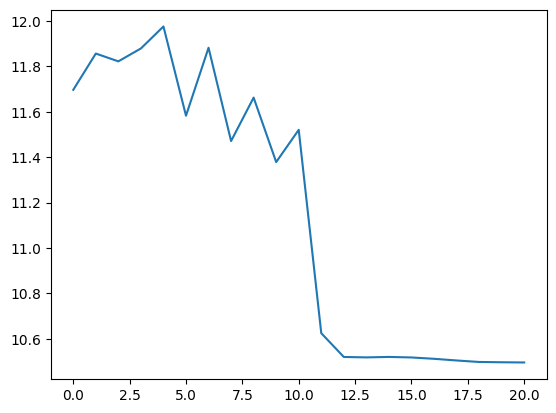

In [65]:
plt.plot(loss_hist)